In [1]:
import os
import random
import numpy as np
import tensorflow as tf
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_text as tf_text
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
def build_model():
  
    model = Sequential()
    model.add(Input(shape= (128, 768), name= 'embedding'))
    model.add(Conv1D(32, 5, activation ='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(6, activation ='softmax'))
    return model

In [5]:
def get_embedding(questions):
    
    text_input = Input(shape=(), dtype=tf.string)
    preprocess_path = "D:/bert_models/bert_en_uncased_preprocess_3"
    path = "D:/electra/electra_base_2"
    preprocess_model = hub.KerasLayer(preprocess_path)    
    encoder = hub.KerasLayer(path)
    
    encoder_inputs = preprocess_model(text_input)
    outputs = encoder(encoder_inputs)["sequence_output"] 

    embedding_model = tf.keras.Model(text_input, outputs)
    embeddings = embedding_model(tf.constant(questions))
    return embeddings

In [6]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    predicted_classes = np.argmax(pred, axis = 1)
    true_classes = np.argmax(y_test, axis = 1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy: {accuracy}")
    f1_ = f1_score(true_classes, predicted_classes, average = 'weighted')
    print(f"F1 score: {f1_}")
    print(classification_report(true_classes, predicted_classes))

In [7]:
def plot_result(log_data): 
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['loss'], label ='train')
    plt.plot(log_data['val_loss'], label ='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['accuracy'], label ='train')
    plt.plot(log_data['val_accuracy'], label ='test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['f1_score'], label ='train')
    plt.plot(log_data['val_f1_score'], label ='test')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [8]:
questions = pd.read_csv('data/combined_dataset.csv')
questions

,QUESTION,BT LEVEL
0,"Suppose prices of two goods are constant, expl...",Comprehension
1,Explain the concept of price leadership observ...,Comprehension
2,Define profit. Briefly explain how accounting ...,Comprehension
3,Describe the assumptions of monopolistic compe...,Comprehension
4,Explain the meaning of the law of diminishing ...,Comprehension
...,...,...
2517,PEST and SWOT are popular strategy tools. Disc...,Application
2518,List the advantages and disadvantages of Publi...,Knowledge
2519,Show your calculations for all THREE (3) optio...,Analysis
2520,Currently the product life cycle for Apple iPo...,Evaluation


In [9]:
X = questions['QUESTION']
cognitive_level = {"Knowledge": 0, "Comprehension": 1, "Application": 2, "Analysis": 3, "Synthesis": 4, "Evaluation": 5}
questions["BT LEVEL"].replace(cognitive_level, inplace = True)
y = questions['BT LEVEL'].values

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(X, y , test_size = 0.10, stratify = questions['BT LEVEL'], 
                                                                             shuffle = True, random_state = 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
X_train_electra_base = get_embedding(X_train)
X_test_electra_base = get_embedding(X_test)

In [12]:
np.save('embedding/electra/embeddings-train.npy', X_train_electra_base)
np.save('embedding/electra/embeddings-test.npy', X_test_electra_base)

In [13]:
X_train_electra_base = np.load('embedding/electra/embeddings-train.npy')
X_test_electra_base = np.load('embedding/electra/embeddings-test.npy')

In [14]:
#model
model = build_model()
# compiling the model
model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics= ['accuracy', tfa.metrics.F1Score(6, 'weighted')])
# printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 32)           122912    
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 123,110
Trainable params: 123,110
Non-trainable params: 0
_________________________________________________________________


In [15]:
training_logger = CSVLogger('log/Electra/base/training.log', separator = ',', append = False)

In [16]:
# fit the model
model.fit(X_train_electra_base, y_train, epochs = 50, batch_size = 8, validation_data = (X_test_electra_base, y_test),
                                                  callbacks = [training_logger], verbose = 1)
#saving the trained model
model.save('saved_models/Electra/base/EQCM.h5')

Epoch 1/50
284/284 [==============================] - 16s 39ms/step - loss: 1.4264 - accuracy: 0.4733 - f1_score: 0.4631 - val_loss: 1.0929 - val_accuracy: 0.5889 - val_f1_score: 0.5576
Epoch 2/50
284/284 [==============================] - 9s 33ms/step - loss: 0.7198 - accuracy: 0.7479 - f1_score: 0.7469 - val_loss: 1.0690 - val_accuracy: 0.6364 - val_f1_score: 0.6340
Epoch 3/50
284/284 [==============================] - 10s 34ms/step - loss: 0.4109 - accuracy: 0.8740 - f1_score: 0.8735 - val_loss: 0.8965 - val_accuracy: 0.7075 - val_f1_score: 0.7012
Epoch 4/50
284/284 [==============================] - 10s 36ms/step - loss: 0.2337 - accuracy: 0.9286 - f1_score: 0.9285 - val_loss: 0.9355 - val_accuracy: 0.7075 - val_f1_score: 0.7122
Epoch 5/50
284/284 [==============================] - 10s 36ms/step - loss: 0.1302 - accuracy: 0.9678 - f1_score: 0.9678 - val_loss: 1.0520 - val_accuracy: 0.7036 - val_f1_score: 0.6884
Epoch 6/50
284/284 [==============================] - 13s 45ms/step - l

In [17]:
log_data = pd.read_csv('log/Electra/base/training.log', sep = ',', engine = 'python')
log_data.head(50)

,epoch,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,0,0.473336,0.463146,1.426405e+00,0.588933,0.557633,1.092949
1,1,0.747907,0.746919,7.198070e-01,0.636364,0.634046,1.069013
2,2,0.873953,0.873532,4.109100e-01,0.707510,0.701153,0.896527
3,3,0.928603,0.928518,2.337417e-01,0.707510,0.712180,0.935515
4,4,0.967827,0.967840,1.302012e-01,0.703557,0.688368,1.052047
5,5,0.983693,0.983680,6.672133e-02,0.715415,0.706390,0.981921
6,6,0.989863,0.989864,4.282786e-02,0.683794,0.686895,1.260240
7,7,0.993389,0.993390,2.965117e-02,0.664032,0.661535,1.517047
8,8,0.996915,0.996916,1.473998e-02,0.723320,0.719914,1.140851
9,9,0.996033,0.996033,1.766485e-02,0.695652,0.694824,1.432638


In [18]:
log_data['val_accuracy'].describe()

count    50.000000
mean      0.714071
std       0.025760
min       0.588933
25%       0.708498
50%       0.719368
75%       0.727273
max       0.750988
Name: val_accuracy, dtype: float64

In [19]:
log_data['val_f1_score'].describe()

count    50.000000
mean      0.708787
std       0.028361
min       0.557633
25%       0.704573
50%       0.713318
75%       0.722675
max       0.743761
Name: val_f1_score, dtype: float64

In [20]:
model.load_weights("saved_models/Electra/base/EQCM.h5")
evaluate_model(model, X_test_electra_base, y_test)

8/8 [==============================] - 1s 25ms/step
Accuracy: 0.7233201581027668
F1 score: 0.7203106746370807
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        35
           1       0.79      0.84      0.81        96
           2       0.62      0.56      0.59        32
           3       0.70      0.77      0.73        30
           4       0.78      0.64      0.71        28
           5       0.62      0.56      0.59        32

    accuracy                           0.72       253
   macro avg       0.70      0.68      0.69       253
weighted avg       0.72      0.72      0.72       253



In [21]:
log_data[['val_accuracy']].idxmax() + 1

val_accuracy    17
dtype: int64

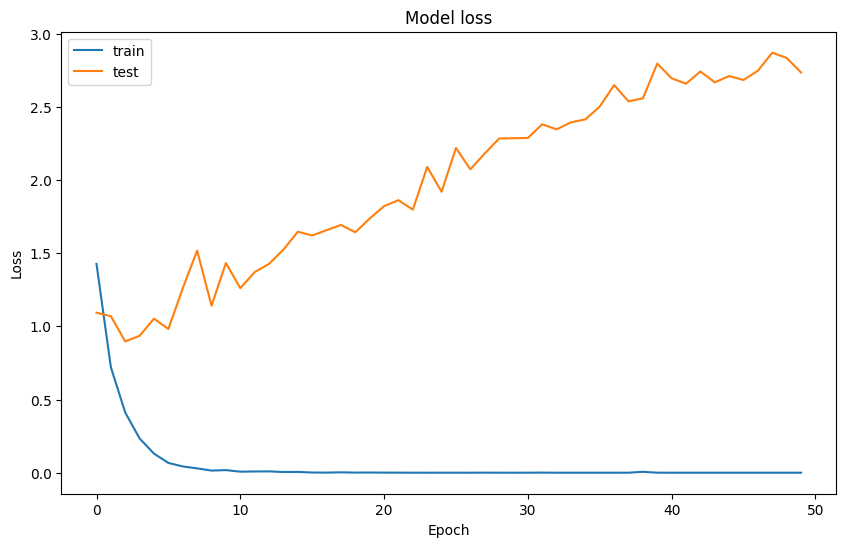

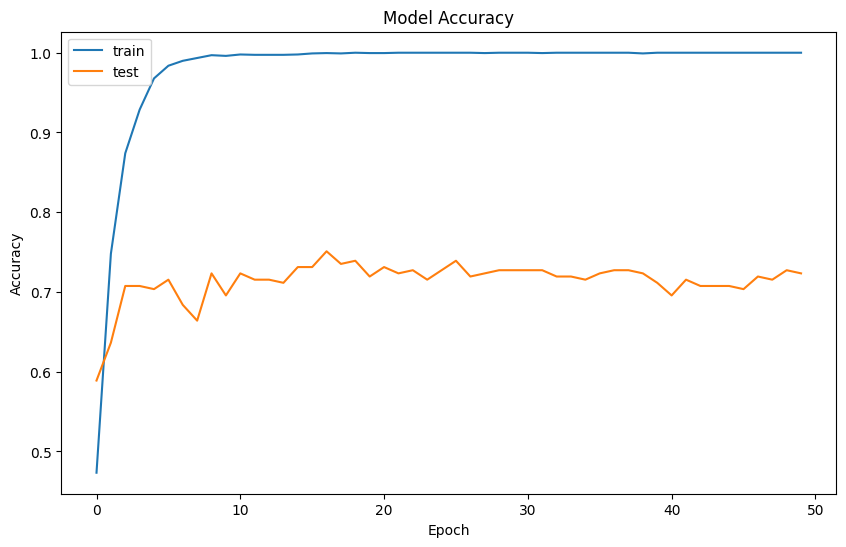

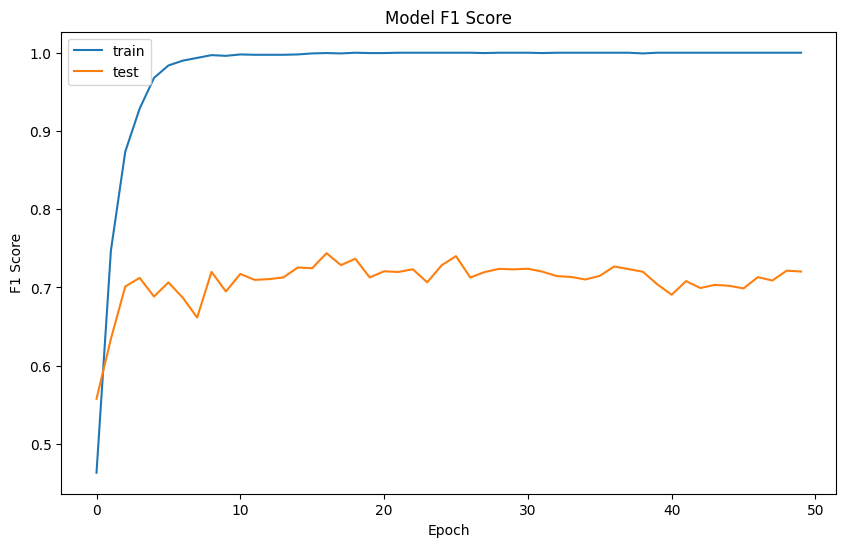

In [22]:
plot_result(log_data)